### Antoine Gorceix

# Monte Carlo Tree Search Methods

In [1]:
from pettingzoo.classic import connect_four_v3

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

In [9]:
class Config:
    def __init__(self):
        self.rows = 6
        self.columns = 7
        self.inarow = 4
        self.timeout = 2

config = Config()

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [10]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# state is a dictionary with two keys: observation and action_mask
print(
    state["observation"].shape
)  # Observation is a numpy array with three coordinates, indicating the positions of the pieces of of player 0 and 1 on the the board
print(state["observation"][:, :, 0])  # Where the pieces of player 0 are
print(state["observation"][:, :, 1])  # Where the pieces of player 1 are

print(state["action_mask"])  # an array showing whether the actions are legal or nots

(6, 7, 2)
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
[1 1 1 1 1 1 1]


# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [11]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask,config, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())

In [12]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask,config, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [13]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs,config, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

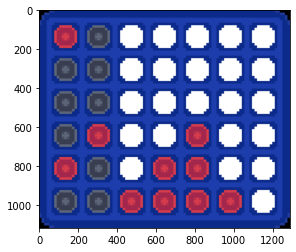

Player 0: Random Player won
[[ 1 -1  0  0  0  0  0]
 [-1 -1  0  0  0  0  0]
 [-1 -1  0  0  0  0  0]
 [-1  1  0  0  1  0  0]
 [ 1 -1  0  1  1  0  0]
 [-1 -1  1  1  1  1  0]]


0

In [14]:
agent0 = RandomPlayer()
agent1 = PlayLeftmostLegal()

play_game(env, agent0, agent1, display=True)

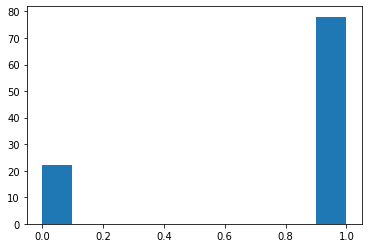

In [15]:
plt.hist([play_game(env, agent0, agent1, display=False) for _ in range(100)])
plt.show()

# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [16]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs,config)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs,config)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [17]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs,config, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

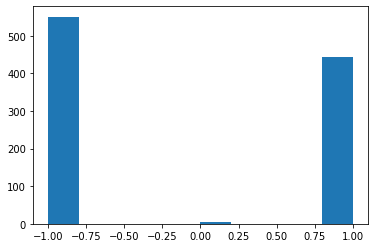

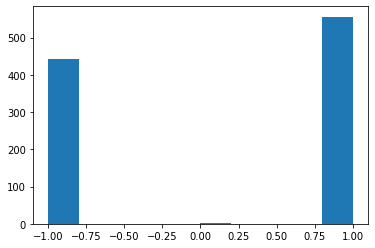

In [18]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).




## Monte Carlo Tree Search with UCB :

In [124]:
### Convertit obs en unique grille contenant des 1 des 2 et des 0 plus facile à exploitée ###
def convert_into(obs):
    o=np.zeros([6,7])
    for i in range(6) :
        for j in range(7):
            if obs["observation"][:, :, 0][i][j]==1:
                o[i][j]=1
            elif obs["observation"][:, :, 1][i][j]==1:
                o[i][j]=2
    return o

In [125]:
### Lors d'une simulation, permet simuler si l'on peut gagner la partie ###
def check_result(grid, piece, config):

    def look_for_window(window):
        return (window.count(piece) == 4 and window.count(0) == config.inarow - 4)

    def calculate_windows():
        is_success = False
        sequences = ['horizontal', 'vertical', 'p_diagonal', 'n_diagonal']

        for sequence_type in sequences:

            if sequence_type == 'horizontal':
                for row in range(config.rows):
                    for col in range(config.columns-(config.inarow-1)):
                        window = list(grid[row, col:col+config.inarow])
                        if look_for_window(window):
                            return True

            elif sequence_type == 'vertical':
                for row in range(config.rows-(config.inarow-1)):
                    for col in range(config.columns):
                        window = list(grid[row:row+config.inarow, col])
                        if look_for_window(window):
                            return True

            elif sequence_type == 'p_diagonal':
                for row in range(config.rows-(config.inarow-1)):
                    for col in range(config.columns-(config.inarow-1)):
                        window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                        if look_for_window(window):
                            return True

            elif  sequence_type == 'n_diagonal':
                for row in range(config.inarow-1, config.rows):
                    for col in range(config.columns-(config.inarow-1)):
                        window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                        if look_for_window(window):
                            return True

        return is_success

    return calculate_windows()

In [126]:
### Fonction qui intervient dans la méthode expansion ###
def put_new_piece(grid, col, mark, config):
    next_state = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if not next_state[row][col]:
            break
    next_state[row][col] = mark
    return next_state

In [119]:
### Notre agent MCTS UCB ###
class MCTS_ucb:

    def __init__(self):
        
        self.name = "Monte Carlo Searh Tree Agent UCB"

    def get_ucb(self, node_no): # Permet de calculer le score UCB
        if not self.total_parent_node_visits:
            return math.inf
        else:
            value_estimate = self.tree[node_no]['total_node_wins'] / (self.tree[node_no]['total_node_visits'] + 1)
            exploration = math.sqrt(2*math.log(self.total_parent_node_visits) / (self.tree[node_no]['total_node_visits'] + 1))
            ucb_score =  value_estimate + self.tunable_constant * exploration
            return ucb_score

    def selection(self): # Étape de sélection
        is_terminal_state = False
        leaf_node_id = (0,)
        while not is_terminal_state:
            node_id = leaf_node_id
            number_of_child = len(self.tree[node_id]['child'])
            if not number_of_child:
                leaf_node_id = node_id
                is_terminal_state = True
            else:
                max_ucb_score = -math.inf
                best_action = leaf_node_id
                for i in range(number_of_child):
                    action = self.tree[node_id]['child'][i]
                    child_id = leaf_node_id + (action,)
                    current_ucb = self.get_ucb(child_id)
                    if current_ucb > max_ucb_score:
                        max_ucb_score = current_ucb
                        best_action = action
                leaf_node_id = leaf_node_id + (best_action,)
        return leaf_node_id

    def expansion(self, leaf_node_id): # Étape d'expansion
        
        current_state = self.tree[leaf_node_id]['state']
        player_mark = self.tree[leaf_node_id]['player']
        current_board = np.asarray(current_state).reshape(config.rows*config.columns)
        self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]
        done = check_result(current_state, player_mark, self.config)
        child_node_id = leaf_node_id
        is_availaible = False

        if len(self.actions_available) and not done:
            childs = []
            for action in self.actions_available:
                child_id = leaf_node_id + (action,)
                childs.append(action)
                new_board = put_new_piece(current_state, action, player_mark, self.config)
                self.tree[child_id] = {'state': new_board, 'player': player_mark,
                                 'child': [], 'parent': leaf_node_id,
                                 'total_node_visits':0, 'total_node_wins':0}

                if check_result(new_board, player_mark, self.config):
                    best_action = action
                    is_availaible = True

            self.tree[leaf_node_id]['child'] = childs
        
            if is_availaible:
                child_node_id = best_action
            else:
                child_node_id = random.choice(childs)

        return leaf_node_id + (child_node_id,)

    def simulation(self, child_node_id): # Étape de simulation
        
        self.total_parent_node_visits += 1
        state = self.tree[child_node_id]['state']
        previous_player = self.tree[child_node_id]['player']

        is_terminal = check_result(state, previous_player, self.config)
        winning_player = previous_player
        count = 0

        while not is_terminal:
            #print('while1')
            current_board = np.asarray(state).reshape(config.rows*config.columns)
            self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]

            if not len(self.actions_available) or count==3:
                winning_player = None
                is_terminal = True

            else:
                count+=1
                if previous_player == 1:
                    current_player = 2
                else:
                    current_player = 1

                for actions in self.actions_available:
                    state = put_new_piece(state, actions, current_player, self.config)
                    result = check_result(state, current_player, self.config)
                    if result: # A player won the game
                        is_terminal = True
                        winning_player = current_player
                        break


            previous_player = current_player

        return winning_player

    def backpropagation(self, child_node_id, winner): # Étape de backpropagation
        
        player = self.tree[(0,)]['player']
        if winner == None:
            reward = 0
        elif winner == player:
            reward = 1
        else:
            reward = -10

        node_id = child_node_id
        self.tree[node_id]['total_node_visits'] += 1
        self.tree[node_id]['total_node_wins'] += reward

    def get_action(self,obs,config,epsilon=None): # La fonction get_action de notre agent
        
        self.state = convert_into(obs)
        self.config = config
        self.player = 2       #obs.mark
        self.final_action = None
        self.time_limit = self.config.timeout - 0.3
        self.root_node = (0,)
        self.tunable_constant = 1.0
        self.tree = {self.root_node:{'state':self.state, 'player':self.player,
                              'child':[], 'parent': None, 'total_node_visits':0,
                              'total_node_wins':0}}
        self.total_parent_node_visits = 0
        self.initial_time = time.time()
        is_expanded = False

        while time.time() - self.initial_time < self.time_limit:
            #print('while')
            node_id = self.selection()
            if not is_expanded:
                node_id = self.expansion(node_id)
                is_expanded = True
            winner = self.simulation(node_id)
            self.backpropagation(node_id, winner)
 
        current_state_node_id = (0,)
        action_candidates = self.tree[current_state_node_id]['child']
        total_visits = -math.inf
        for action in action_candidates:
            action = current_state_node_id + (action,)
            visit = self.tree[action]['total_node_visits']
            if visit > total_visits:
                total_visits = visit
                best_action = action
      
        return best_action[1]

In [120]:
class Config:
    def __init__(self):
        self.rows = 6
        self.columns = 7
        self.inarow = 4
        self.timeout = 2

config = Config()
#mcts_agent = MCTS_PettingZoo(config)

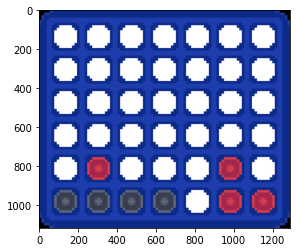

Player 1: Monte Carlo Searh Tree Agent won
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0 -1  0  0  0 -1  0]
 [ 1  1  1  1  0 -1 -1]]


1

In [121]:
agent0 = RandomPlayer()
agent1 = MCTS_ucb()

play_game(env, agent0, agent1, display=True)

## Monte Carlo Tree Search with Rave :

In [127]:
### Notre agent MCTS Rave ###
class MCTS_rave:

    def __init__(self):
        
        self.name = "Monte Carlo Searh Tree Agent withe rave"

    def get_rave(self, node_no): # Permet d'estimer le score Rave
        if not self.total_parent_node_visits:
            return math.inf
        else:
            beta = math.sqrt(self.k / (3 * self.total_parent_node_visits + self.k))
            value_estimate = (1 - beta) * (self.tree[node_no]['total_node_wins'] / (self.tree[node_no]['total_node_visits'] + 1)) + beta * (
                self.tree[node_no]['total_rave_wins'] / (self.tree[node_no]['total_rave_visits'] + 1))
            exploration = math.sqrt(2 * math.log(self.total_parent_node_visits) / (self.tree[node_no]['total_node_visits'] + 1))
            ucb_score = value_estimate + self.tunable_constant * exploration
            return ucb_score

    def selection(self):
        is_terminal_state = False
        leaf_node_id = (0,)
        while not is_terminal_state:
            node_id = leaf_node_id
            number_of_child = len(self.tree[node_id]['child'])
            if not number_of_child:
                leaf_node_id = node_id
                is_terminal_state = True
            else:
                max_ucb_score = -math.inf
                best_action = leaf_node_id
                for i in range(number_of_child):
                    action = self.tree[node_id]['child'][i]
                    child_id = leaf_node_id + (action,)
                    current_ucb = self.get_rave(child_id)
                    if current_ucb > max_ucb_score:
                        max_ucb_score = current_ucb
                        best_action = action
                leaf_node_id = leaf_node_id + (best_action,)
        return leaf_node_id

    def expansion(self, leaf_node_id):
        
        current_state = self.tree[leaf_node_id]['state']
        player_mark = self.tree[leaf_node_id]['player']
        current_board = np.asarray(current_state).reshape(config.rows*config.columns)
        self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]
        done = check_result(current_state, player_mark, self.config)
        child_node_id = leaf_node_id
        is_availaible = False

        if len(self.actions_available) and not done:
            childs = []
            for action in self.actions_available:
                child_id = leaf_node_id + (action,)
                childs.append(action)
                new_board = put_new_piece(current_state, action, player_mark, self.config)
                self.tree[child_id] = {'state': new_board, 'player': player_mark,
                                 'child': [], 'parent': leaf_node_id,
                                 'total_node_visits':0, 'total_node_wins':0,
                                 'total_rave_visits': 0, 'total_rave_wins': 0}

                if check_result(new_board, player_mark, self.config):
                    best_action = action
                    is_availaible = True

            self.tree[leaf_node_id]['child'] = childs
        
            if is_availaible:
                child_node_id = best_action
            else:
                child_node_id = random.choice(childs)

        return leaf_node_id + (child_node_id,)

    def simulation(self, child_node_id):
        
        self.total_parent_node_visits += 1
        state = self.tree[child_node_id]['state']
        previous_player = self.tree[child_node_id]['player']

        is_terminal = check_result(state, previous_player, self.config)
        winning_player = previous_player
        count = 0

        while not is_terminal:
            #print('while1')
            current_board = np.asarray(state).reshape(config.rows*config.columns)
            self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]

            if not len(self.actions_available) or count==3:
                winning_player = None
                is_terminal = True

            else:
                count+=1
                if previous_player == 1:
                    current_player = 2
                else:
                    current_player = 1

                for actions in self.actions_available:
                    state = put_new_piece(state, actions, current_player, self.config)
                    result = check_result(state, current_player, self.config)
                    if result: # A player won the game
                        is_terminal = True
                        winning_player = current_player
                        break


            previous_player = current_player

        return winning_player

    def backpropagation(self, child_node_id, winner):
        
        player = self.tree[(0,)]['player']
        if winner == None:
            reward = 0
        elif winner == player:
            reward = 1
        else:
            reward = -10

        node_id = child_node_id
        self.tree[node_id]['total_node_visits'] += 1
        self.tree[node_id]['total_node_wins'] += reward
        node_id = child_node_id
        while node_id != (0,):
            for action in self.tree[node_id]['child']:
                rave_child_id = node_id + (action,)
                if action in self.actions_available:
                    self.tree[rave_child_id]['total_rave_visits'] += 1
                    if winner == self.tree[rave_child_id]['player']:
                        self.tree[rave_child_id]['total_rave_wins'] += 1
            node_id = self.tree[node_id]['parent']

    def get_action(self,obs,config,epsilon=None,k=5000):
        
        self.k = k  # RAVE parameter
        self.state = convert_into(obs)
        self.config = config
        self.player = 1       #obs.mark
        self.final_action = None
        self.time_limit = self.config.timeout - 0.3
        self.root_node = (0,)
        self.tunable_constant = 1.0
        self.tree = {self.root_node:{'state':self.state, 'player':self.player,
                              'child':[], 'parent': None, 'total_node_visits':0,
                              'total_node_wins':0}}
        self.total_parent_node_visits = 0
        self.initial_time = time.time()
        is_expanded = False

        while time.time() - self.initial_time < self.time_limit:
            #print('while')
            node_id = self.selection()
            if not is_expanded:
                node_id = self.expansion(node_id)
                is_expanded = True
            winner = self.simulation(node_id)
            self.backpropagation(node_id, winner)
 
        current_state_node_id = (0,)
        action_candidates = self.tree[current_state_node_id]['child']
        total_visits = -math.inf
        for action in action_candidates:
            action = current_state_node_id + (action,)
            visit = self.tree[action]['total_node_visits']
            if visit > total_visits:
                total_visits = visit
                best_action = action
      
        return best_action[1]

In [128]:
class Config:
    def __init__(self):
        self.rows = 6
        self.columns = 7
        self.inarow = 4
        self.timeout = 2

config = Config()

In [ ]:
agent1 = RandomPlayer()
agent0 = MCTS_rave()

play_game(env, agent0, agent1, display=True)

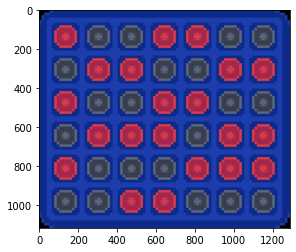

Draw


0.5

In [99]:
agent1 = MCTS_ucb()
agent0 = MCTS_rave()

play_game(env, agent0, agent1, display=True)

On les fait jouer l'un contre l'autre :

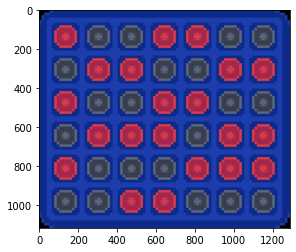

Draw


0.5

In [100]:
agent1 = MCTS_ucb()
agent0 = MCTS_rave()

play_game(env, agent0, agent1, display=True)

## Evaluating performances of MCTS methods :

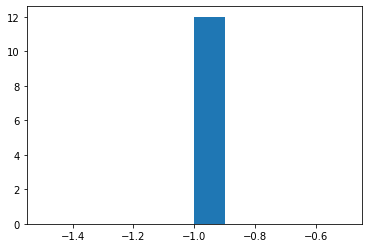

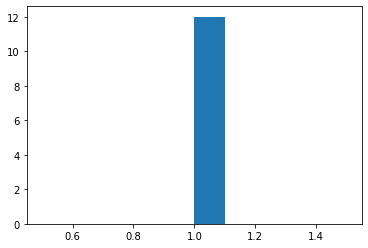

In [108]:
plt.hist(eval_against_policy(env, MCTS_ucb(), MCTS_ucb(), N_episodes=12, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, MCTS_ucb(), MCTS_ucb(), N_episodes=12, first_player=True))
plt.show()

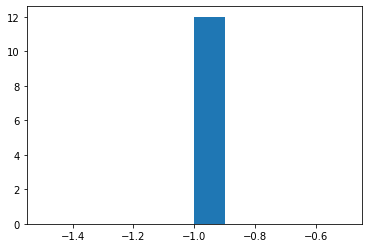

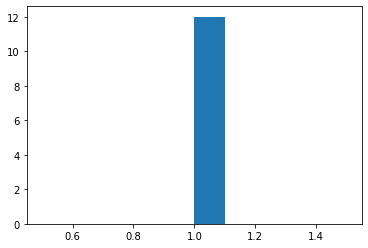

In [112]:
plt.hist(eval_against_policy(env, MCTS_rave(), MCTS_rave(), N_episodes=12, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, MCTS_rave(), MCTS_rave(), N_episodes=12, first_player=True))
plt.show()

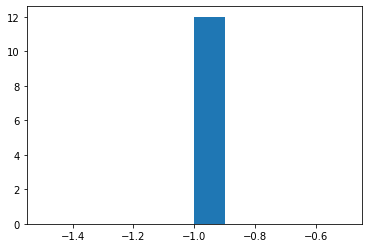

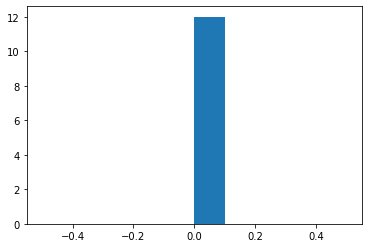

In [109]:
plt.hist(eval_against_policy(env, MCTS_rave(), MCTS_ucb(), N_episodes=12, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, MCTS_rave(), MCTS_ucb(), N_episodes=12, first_player=True))
plt.show()

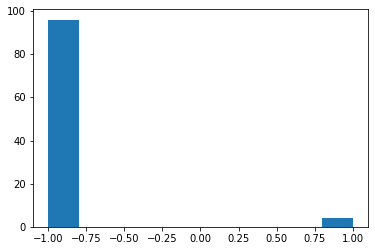

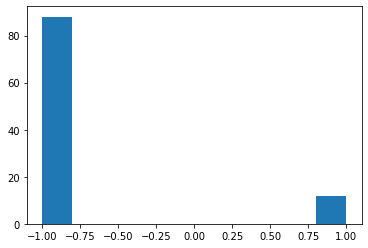

In [115]:
plt.hist(eval_against_policy(env, RandomPlayer(), MCTS_ucb(), N_episodes=100, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), MCTS_ucb(), N_episodes=100, first_player=True))
plt.show()

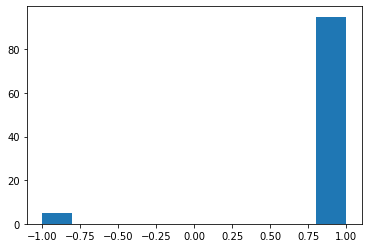

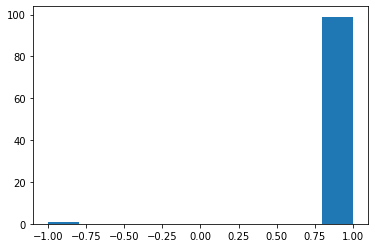

In [129]:
plt.hist(eval_against_policy(env,  MCTS_rave(),RandomPlayer(), N_episodes=100, first_player=False))
plt.show()
plt.hist(eval_against_policy(env,  MCTS_rave(),RandomPlayer(), N_episodes=100, first_player=True))
plt.show()